In [1]:
%load_ext rpy2.ipython
%matplotlib inline

from neuralprophet import Prophet
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')

You may have noticed in the earlier examples in this documentation that real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

### Automatic changepoint detection in Prophet
Prophet detects changepoints by first specifying a large number of *potential changepoints* at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of *possible* places where the rate can change, but will use as few of them as possible. Consider the Peyton Manning forecast from the Quickstart. By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed:

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 142


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.64E-02, min: 1.36E-01


  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.98E-02, min: 1.36E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.70E-02
Epoch[142/142]: 100%|██████████| 142/142 [00:11<00:00, 12.23it/s, SmoothL1Loss=0.00561, MAE=0.332, RMSE=0.464, Loss=0.00766, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_fo

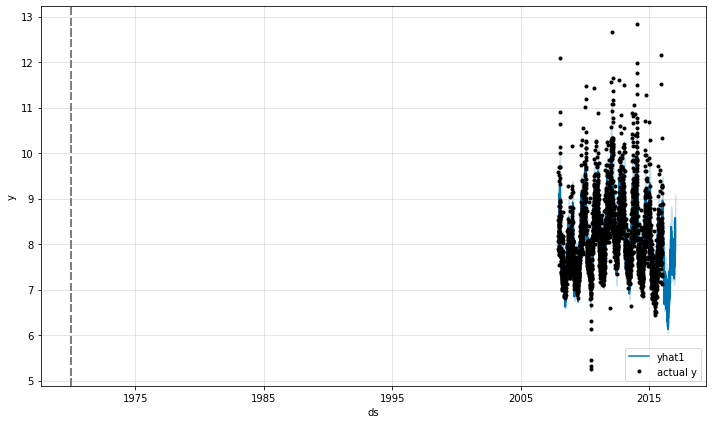

In [6]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)
fig = m.plot(forecast)
for cp in m.config_trend.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=2)

Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused. We can see this by plotting the magnitude of the rate change at each changepoint:

In [8]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

AttributeError: 'Prophet' object has no attribute 'params'

The number of potential changepoints can be set using the argument `n_changepoints`, but this is better tuned by adjusting the regularization. The locations of the signification changepoints can be visualized with:

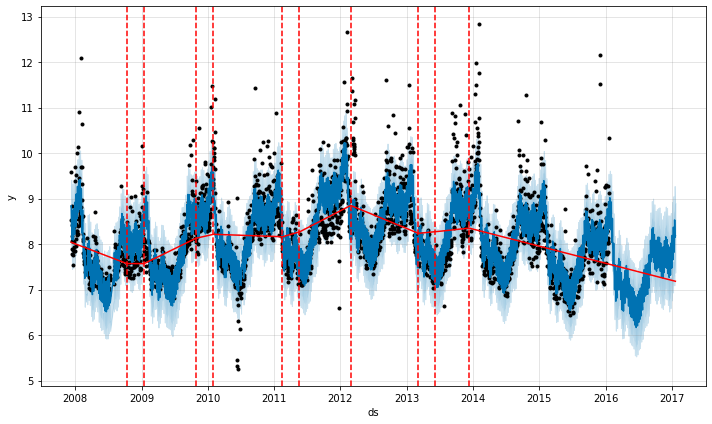

In [4]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the `changepoint_range` argument. For example, `m = Prophet(changepoint_range=0.9)` in Python or `m <- prophet(changepoint.range = 0.9)` in R will place potential changepoints in the first 90% of the time series.

### Adjusting trend flexibility
If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. Increasing it will make the trend *more* flexible:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8043.87    0.00107746       391.804           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8073.57     0.0086965        419.33           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8094.59    0.00823391       152.873           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8112.48    0.00396146       286.468           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8128.62    0.00627886       265.611           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

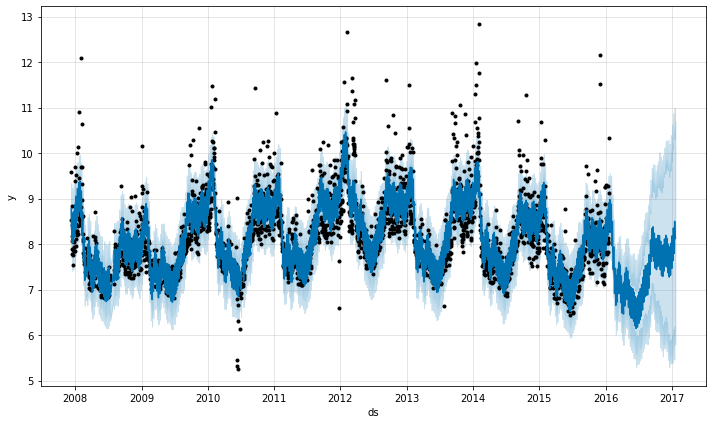

In [5]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

Decreasing it will make the trend *less* flexible:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55        7632.2   0.000726159       3915.52   1.743e-07       0.001      111  LS failed, Hessian reset 
      99       7634.95   1.18157e-06       3271.92      0.2476           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       7634.96   2.82882e-07       3843.26   7.933e-11       0.001      243  LS failed, Hessian reset 
     130       7634.96   3.73205e-09       2767.97      0.1291      0.3962      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


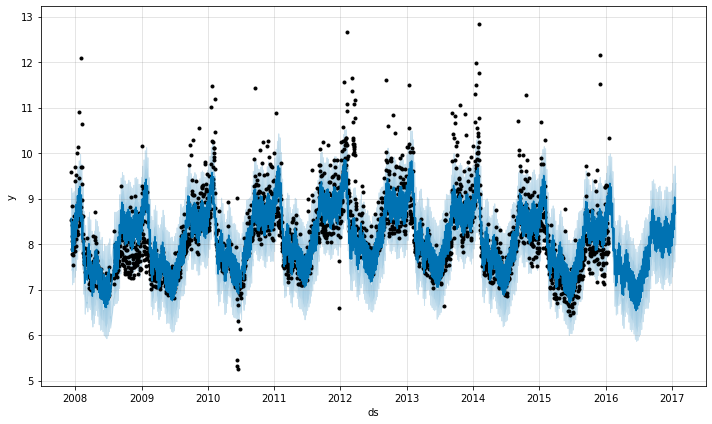

In [6]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

When visualizing the forecast, this parameter can be adjusted as needed if the trend seems to be over- or under-fit. In the fully-automated setting, see the documentation on cross validation for recommendations on how this parameter can be tuned.

### Specifying the locations of the changepoints

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the `changepoints` argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates, as is done here:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      33       7794.72    3.3088e-05       2.51227      0.3682      0.9927       46   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


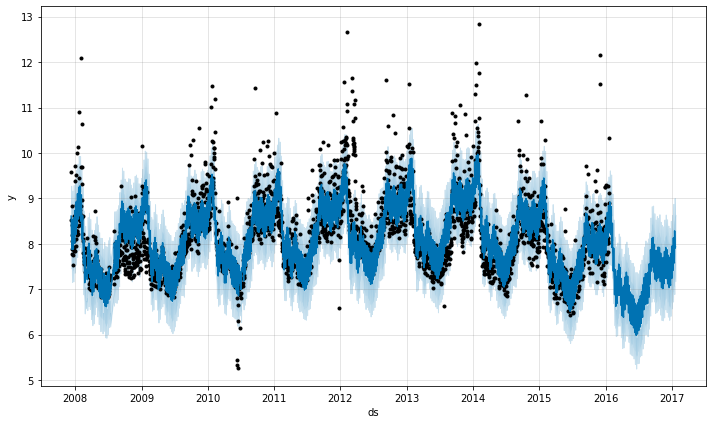

In [8]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)